In [172]:
#pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git
#!python -m spacy download es

SyntaxError: ignored

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')


In [0]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

from os import listdir
from os.path import isfile, join

# comp-linguistics
import spacy
import nltk
from spacy import displacy
#Using NLP in spanish
nlp = spacy.load("es")

%matplotlib inline

In [0]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [0]:
text_folder = '/content/txt'
text_dic = {}
onlyfiles = [f for f in listdir(text_folder) if isfile(join(text_folder, f))]

for file in onlyfiles:
    f = open(text_folder + '/' + file, "r")
    text_dic[file] = {}
    text_dic[file]['name'] = file
    text_dic[file]['text'] = f.read()
    
#Using the modified version of clean_raw_text function, incorporating it into my own code, we build 
#the lists of tokenized texts for every speech
for index, data in text_dic.items():
    text_dic[index]['clean_text'] = text_dic[index]['text'].replace(" \'m", "'m") \
        .replace(" \'ll", "'ll").replace(" \'re", "'re") \
        .replace(" \'s", "'s").replace(" \'re", "'re")\
        .replace("\n", "").replace("\x0c", "")
    text_dic[index]['token_word_list'] = word_tokenize(text_dic[index]['clean_text'])

In [0]:
df_text = pd.DataFrame(text_dic)
df_text = df_text.T 

In [0]:
df_text['tokenized_sents'] = df_text['clean_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
df_text['normalized_sents'] = df_text['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [180]:
print(len(df_text['normalized_sents'][11:12].sum()))
print(len(df_text['normalized_sents'][:10].sum()))
print(len(df_text['normalized_sents'][:11].sum()))

2120
28650
31080


In [0]:
g = wordCooccurrence(df_text['normalized_sents'].sum())

In [182]:
g

In [183]:
len(g.nodes)

13467

In [184]:
len(g.edges)

220252

In [185]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [186]:
mat = nx.to_numpy_matrix(g)
mat.shape

(13467, 13467)

In [0]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized
import sklearn.feature_extraction


In [0]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(df_text['clean_text'])
#print(senVects_incidence.toarray())
#print(senVectorizer.get_feature_names()[:90])


In [189]:
len(senVectorizer.get_feature_names())

13912

In [190]:
senVects_incidence.shape

(19, 13912)

In [0]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [192]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 13931
Number of edges: 41591
Average degree:   5.9710


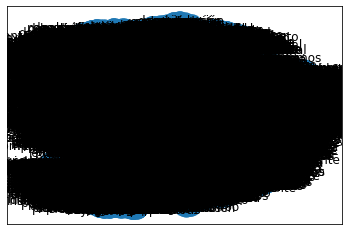

In [193]:
nx.draw_networkx(g_2mode)

In [0]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [0]:
gDoc = contractNetwork(g_2mode, 'doc')

In [196]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 19
Number of edges: 171
Average degree:  18.0000


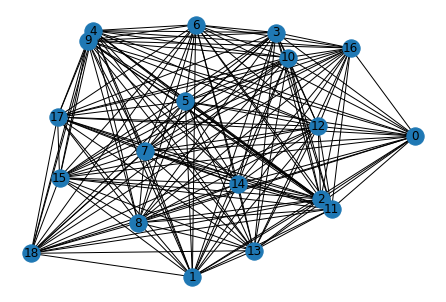

In [197]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

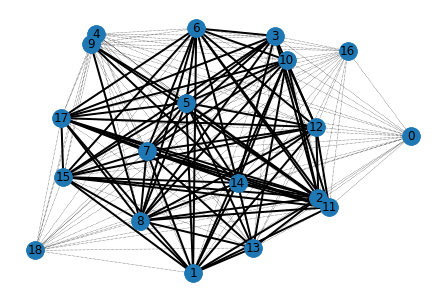

In [198]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [0]:
#print(len(df_text.iloc[18]['text']),"words:","\n",df_text.iloc[18]['text'].strip().replace('  ', '\n'))

In [0]:
#print(len(df_text.iloc[16]['text']),"words:","\n",df_text.iloc[6]['text'].strip().replace('  ', '\n'))

In [0]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

In [0]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

In [0]:
g = wordCooccurrence(df_text['normalized_sents'].sum())

In [0]:
len(g)

In [0]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 100])

In [0]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [0]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [0]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

In [0]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [0]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

In [0]:
c[0]

In [0]:
giant = nx.Graph(giant)

In [0]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

In [0]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [0]:
emergenciaNeighbors = gWord.neighbors('emergencia')
emergenciaNeighborsPlus1 = set(emergenciaNeighbors)
for n in emergenciaNeighbors:
    emergenciaNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in emergenciaNeighborsPlus1:
#    print(x)

In [0]:
g_emergencia2 = giant.subgraph(emergenciaNeighborsPlus1)
print(nx.info(g_emergencia2))

In [0]:
layout_amer = nx.spring_layout(g_emergencia2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_emergencia2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_emergencia2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_emergencia2.edges(data = True)))
nx.draw(g_emergencia2, ax = ax, pos = layout_amer, labels = {n:n for n in g_emergencia2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_emergencia2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

In [0]:
dcentralities = nx.degree_centrality(giant)

In [0]:
#max(dcentralities.items(), key = lambda x : x[1])

In [0]:
from collections import Counter
k = Counter(dcentralities)
highest = k.most_common(45)
highest 

In [0]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [0]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [0]:
plt.hist(list(dcentralities.values()))
plt.show()

In [0]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

In [0]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

In [0]:
bcentralities = nx.betweenness.betweenness_centrality(giant)

In [0]:
bcentralities['peruano']

In [0]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(bcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [bcentralities[n] / maxC for n in giant.nodes],
        node_size = [bcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [0]:
plt.hist(list(bcentralities.values()))
plt.show()

In [0]:
sorted(bcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

In [0]:
sorted(bcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

In [0]:
ccentralities = nx.closeness_centrality(giant)

In [0]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(ccentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [ccentralities[n] / maxC for n in giant.nodes],
        node_size = [ccentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [0]:
sorted(ccentralities.items(), key = lambda x: x[1], reverse = True)[:10]

In [0]:
sorted(ccentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

With eigenverctor centrality 



In [0]:
ecentralities = nx.eigenvector_centrality(giant)

In [0]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(ecentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [ecentralities[n] / maxC for n in giant.nodes],
        node_size = [ecentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [0]:
plt.hist(list(ecentralities.values()))
plt.show()

In [0]:
sorted(ecentralities.items(), key = lambda x: x[1], reverse = True)[:10]

In [0]:
sorted(ecentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

In [0]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [0]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

In [0]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [0]:
nx.density(giant)

In [0]:
np.mean([v for w,v in nx.degree(giant)])

In [0]:
nx.diameter(giant)